In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import datetime
from scipy import stats 
from datetime import datetime, timedelta
import time
import sklearn as sk
import nltk
import sqlite3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import random
import sys
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from pyathena import connect
# import pandas as pd
# conn = connect(s3_staging_dir='<ATHENA QUERY RESULTS LOCATION>',
#                region_name='us-east-2')

# df = pd.read_sql("SELECT * FROM athenaquery.<YOUR TABLE NAME> limit 8;", conn)


In [5]:
#import data and review content
# conn = sqlite3.connect('JobDBa.db')
# cur = conn.cursor()
#21000 job descriptions at this time
# cur.execute('SELECT * FROM [Jobs Indeed]')
# data = cur.fetchall()
# dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
dfa = pd.read_csv('jobclust.csv')
# print(dfa.describe())
# dfa.isna().sum()
dfa.drop(dfa.columns[0], axis=1, inplace=True)
dfa.head(5)


Job Title          Company       Location  \
0  Data Analyst - Energy Savings Programs  Ecotagious Inc.  Vancouver, BC   
1                          Head of Growth         Hostaway    Toronto, ON   
2     Field Sales Trainer: Eastern Canada        JUUL Labs    Toronto, ON   
3                          Cloud Engineer    Dialpad, Inc.  Vancouver, BC   
4                         SEO/SEM Manager          Patsnap    Toronto, ON   

                                         Description  
0  Ecotagious is a cleantech software company cur...  
1  Hostaway is the fastest-growing global SaaS st...  
2  --------------------------------\r\nSr Manager...  
3  Dialpad's product suite covers the full range ...  
4  PatSnap vision\r\nPatSnap is a global, hyper-g...

**From initial observations on the dataset, there have been no issues with the scraper getting all intact data from indeed. There are no missing values for any of the scraped information categories. The current dataset has 21,000 unique job descriptions to perform clustering on.** 

In [6]:
#language processing by removing stop words, punctuation and perform vectorization
punc = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'", ''] #remove punctuation for initial analysis
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = dfa['Description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)
word_features = vectorizer.get_feature_names()
print(len(word_features))


99452


In [7]:
stemmer = SnowballStemmer('english')
stopw = nltk.corpus.stopwords.words('english')
stop_words = stop_words.union(stopw)
def tokenize(txt):
    return [stemmer.stem(word) for word in word_tokenize(txt.lower())]

In [9]:
dftok = dfa.copy()
tok = []
lem = []
stem = []
stop = []
stopstem = []
for index,row in dftok.iterrows():
    x = word_tokenize(row['Description'])
    y = [lemma.lemmatize(word) for word in word_tokenize(row['Description'].lower())]
    z = [stemmer.stem(word) for word in word_tokenize(row['Description'].lower())]
    h = [n for n in word_tokenize(row['Description'].lower()) if not n in stop_words]
    e = [stemmer.stem(word) for word in h]
    tok.append(x)
    lem.append(y)
    stem.append(z)
    stop.append(h)
    stopstem.append(e)

NameError: name 'lemma' is not defined

In [7]:
dftok['Description Token'] = tok
dftok['Description Lem'] = lem
dftok['Description Stem'] = stem
dftok['Description Stop'] = stop
dftok['Description Stopstem']=stopstem
dftok.head(5)
show different transformation's effect on language data

Job Title          Company       Location  \
0  Data Analyst - Energy Savings Programs  Ecotagious Inc.  Vancouver, BC   
1                          Head of Growth         Hostaway    Toronto, ON   
2     Field Sales Trainer: Eastern Canada        JUUL Labs    Toronto, ON   
3                          Cloud Engineer    Dialpad, Inc.  Vancouver, BC   
4                         SEO/SEM Manager          Patsnap    Toronto, ON   

                                         Description  \
0  Ecotagious is a cleantech software company cur...   
1  Hostaway is the fastest-growing global SaaS st...   
2  --------------------------------\nSr Manager, ...   
3  Dialpad's product suite covers the full range ...   
4  PatSnap vision\nPatSnap is a global, hyper-gro...   

                                   Description Token  \
0  [Ecotagious, is, a, cleantech, software, compa...   
1  [Hostaway, is, the, fastest-growing, global, S...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [Dialpad, 's, product, suite, covers, the, ful...   
4  [PatSnap, vision, PatSnap, is, a, global, ,, h...   

                                     Description Lem  \
0  [ecotagious, is, a, cleantech, software, compa...   
1  [hostaway, is, the, fastest-growing, global, s...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [dialpad, 's, product, suite, cover, the, full...   
4  [patsnap, vision, patsnap, is, a, global, ,, h...   

                                    Description Stem  \
0  [ecotagi, is, a, cleantech, softwar, compani, ...   
1  [hostaway, is, the, fastest-grow, global, saa,...   
2  [--, --, --, --, --, --, --, --, --, --, --, -...   
3  [dialpad, 's, product, suit, cover, the, full,...   
4  [patsnap, vision, patsnap, is, a, global, ,, h...   

                                    Description Stop  \
0  [ecotagious, cleantech, software, company, cur...   
1  [hostaway, fastest-growing, global, saas, star...   
2  [sr, manager, field, sales, training, company,...   
3  [dialpad, 's, product, suite, covers, range, m...   
4  [patsnap, vision, patsnap, global, hyper-growt...   

                                Description Stopstem  
0  [ecotagi, cleantech, softwar, compani, current...  
1  [hostaway, fastest-grow, global, saa, start-up...  
2  [sr, manag, field, sale, train, compani, juul,...  
3  [dialpad, 's, product, suit, cover, rang, mode...  
4  [patsnap, vision, patsnap, global, hyper-growt...

In [9]:
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize)
tvs = tvec.fit_transform(dftok['Description'])
featname = tvec.get_feature_names()
# print(featname)
# print(len(featname))


D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", '``', 'abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


["''", "'d", "'m", "'s", '**', '***', '****', '*****', '******', '*******', '**********', '***********', '************', '*************', '**************', '***************', '****************', '*****************', '******************', '*******************', '********************', '*********************', '**********************', '***********************', '*************************', '**************************', '***************************', '****************************', '*******************************', '********************************', '***********************************', '****************************************', '*****************************************', '***********************************************', '*************************************************', '**************************************************', '******************************************************', '************************************************************', '***********************************

From observing the feature name list, I have identified a large variety of junk that was not filtered out by the default nltk word_tokenize and punctuation+stopword removal.

Issues include:

Long strings of unnecessary puntuation
'++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++'

Words beginning with punctuation
*onsit , '-network', '.client'

Irrelevant strings, likely part of url 
'//a16z.com/portfolio' , '//aws.amazon.com'

Words separated by punctuation
'accessibility.analyz', 'access/entitl'

Words combined together
'accessibilitywalmart'

To fix, I will use custom regex tokenizer to separate by additional punctuation. 

In [9]:
Text1 = "argumentFlow FlashTextInterface YOgurt ran.SOM ranSom URM 905raptors. 905Raptors 3Years"
txt2 = "argumentFlow r.anSom .random random. flow-chart overview/close"
t = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", Text1)
k = re.sub(r"([-./])([a-z0-9A-Z])", r"\1 \2", txt2)
print(t)
print(k)
#fix cases where words are combined together with capitalizations
#fixed cases where punctuation connects words, preventing proper vectorization as well


argument Flow FlashTextInterface YOgurt ran.SOM ran Som URM 905raptors. 905 Raptors 3 Years
argumentFlow r. anSom . random random. flow- chart overview/ close


In [26]:
#comparing outputs
def regtoken(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@+!)?(\'^_-]", punc)
    return tok
# print(dftok['Description'][0])
# print(word_tokenize(dftok['Description'][0]))
# print(regtoken(dftok['Description'][0]))

Ecotagious is a cleantech software company currently experiencing rapid growth in customers, people and revenues. Our flexible product platform combines a wide range of IoT and energy data, advanced big-data analytics, machine learning and social psychology to help utilities reduce energy demand and meet energy efficiency targets.To ensure our energy analytic products are optimized, delivering accurate results that lead directly to customer savings, and to help continuously improve and innovate our range of product offerings, we’re currently seeking a Data Analyst for our Energy Savings Programs.The opportunity: As a Data Analyst, you’ll be responsible for planning, customizing and measuring the success of our energy saving software solutions.Reporting to the Director, Program Management, collaborating closely with Customer Success Managers and Product Owners, this role is a central opportunity to refine and target our innovative energy conservation solutions and to and deliver industr

In [11]:
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=regtoken)
tvs = tvec.fit_transform(dftok['Description'])
featname = tvec.get_feature_names()
# print(featname)
# print(len(featname))
#custom regex cuts feature space to 98k from 138k

['""', '"[we]', '"\x98human', '"•', '0', '00', '000', '0000', '000001', '00000412', '0000190051', '00002564', '00003697', '00004491', '00004567', '00004652', '00004660', '00004832', '00005043', '00005109', '00005141', '00005146', '00005183', '00005209', '00005247', '00005399', '000073applications', '00007738', '000078applications', '00010861', '000119312516530910', '00011985', '00012579', '00012834', '000162', '0001job', '0002', '00047066', '00047871', '00052225', '00053015', '00053079', '00053261', '00053425', '00053485', '00097315', '000application', '000benefits', '000how', '000job', '000lbs', '000s', '000sf', '000sign', '000strategize', '000th', '000year', '000~', '000–', '000欢迎应届毕业留学生申请', '000～', '001', '00123049', '0018', '001820', '001job', '001”', '002', '002352', '0025', '002653', '002842', '003', '003013', '0038156', '0039025', '0039138', '004', '0041', '0046', '0047', '005', '00665', '007', '008', '008631', '0090', '009474', '00a', '00am', '00amwalk', '00location', '00p', '0

In [3]:
def regstemtoken(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@+!)?(\'^_-]", punc.lower())
    h = [n for n in tok if not n in stop_words]
    stem = [stemmer.stem(word) for word in h]
    return stem
tvec = TfidfVectorizer(stop_words=stop_words, tokenizer=regstemtoken)
tvs = tvec.fit_transform(dfa['Description'])
featname = tvec.get_feature_names()
# print(featname)
# print(len(featname))
#with stem reduced to 79k, 20k below initial, still many words that have been combined together

NameError: name 'stop_words' is not defined

In [30]:
#find optimal k value
# avgsum = []
# for i in range(0,1):
#     random.shuffle(data)
#     d1 = data[:5000]
#     d2 = data[5000:10000]
#     d3 = data[10000:15000]
#     d4 = data[15000:20000]
#     dlist = [d1, d2, d3, d4]
#     sumsum = []
#     for d in dlist:
#         dl=pd.DataFrame(data=d, columns=['Job Title', 'Company','Location','Description'])
#         tvec = TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
#         tvs = tvec.fit_transform(dl['Description'])
# #         shp = tvs.shape
#         Sum_of_squared_distances = []
#         K = range(10,30,2)
#         for k in K:
#             km = KMeans(n_clusters=k)
#             km = km.fit(tvs)
#             Sum_of_squared_distances.append(km.inertia_)
#         sumsum.append(Sum_of_squared_distances)
#     sumt= np.transpose(sumsum)
#     smta = []
#     for item in sumt:
#         sm = 0
#         for number in item:
#             sm+=number
#         sm = sm/4
#         smta.append(sm)
#     avgsum.append(smta)
# avgt= np.transpose(avgsum)
# avgss = []
# for item in avgt:
#     sm = 0
#     for number in item:
#         sm+=number
#     sm = sm/5
#     avgss.append(sm)
# K =range(10,30,2)
# plt.plot(K, avgss, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [ ]:
tvec = TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
tvs = tvec.fit_transform(dftok['Description'])
shp = tvs.shape
Sum_of_squared_distances = []
K = range(10,30,2)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tvs)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u"'d", u"'s", '``', u'abov', u'afterward', u'alon', u'alreadi', u'alway', u'ani', u'anoth', u'anyon', u'anyth', u'anywher', u'becam', u'becaus', u'becom', u'befor', u'besid', u'cri', u'describ', u'doe', u'dure', u'els', u'elsewher', u'empti', u'everi', u'everyon', u'everyth', u'everywher', u'fifti', u'forti', u'henc', u'hereaft', u'herebi', u'howev', u'hundr', u'inde', u'mani', u'meanwhil', u'moreov', u"n't", u'need', u'nobodi', u'noon', u'noth', u'nowher', u'onc', u'onli', u'otherwis', u'ourselv', u'perhap', u'pleas', u'sever', u'sha', u'sinc', u'sincer', u'sixti', u'someon', u'someth', u'sometim', u'somewher', u'themselv', u'thenc', u'thereaft', u'therebi', u'therefor', u'togeth', u'twelv', u'twenti', u'veri', u'whatev', u'whenc', u'whenev', u'wherea', 

In [17]:
# #limit max appearance of word 
# tvec = TfidfVectorizer(max_df=0.8, min_df=0.3, ngram_range=(1,3), stop_words=stop_words, tokenizer=regstemtoken)
# tvs = tvec.fit_transform(dftok['Description'])
# featname = tvec.get_feature_names()
# print(tvs.shape)
# lst = [0]*158115
# for item in tvs:
#     lt = item.toarray()[0]
#     for i in range(0,(len(lt))):
#         out = lt[i]+lst[i]
#         lst[i] = out
# for s in range(0,(len(lst))):
#     lst[s] = lst[s]/21187
    
# dic = tvec.vocabulary_
# name = [None]*158115

# for key,value in dic.items():
#     val = int(value)
#     name[val]= key

(21187, 158115)


In [10]:
dfs = dfa.sample(frac=.15)
dfs.describe()


Job Title                    Company    Location  \
count             3812                       3812        3812   
unique            3011                       2375         687   
top     Data Scientist  Amazon.com Services, Inc.  Austin, TX   
freq                93                         69         167   

                                              Description  
count                                                3812  
unique                                               3812  
top     Position: Python DeveloperLocation: Seattle WA...  
freq                                                    1

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u"'d", u"'s", '``', u'abov', u'afterward', u'alon', u'alreadi', u'alway', u'ani', u'anoth', u'anyon', u'anyth', u'anywher', u'becam', u'becaus', u'becom', u'befor', u'besid', u'cri', u'describ', u'doe', u'dure', u'els', u'elsewher', u'empti', u'everi', u'everyon', u'everyth', u'everywher', u'fifti', u'forti', u'henc', u'hereaft', u'herebi', u'howev', u'hundr', u'inde', u'mani', u'meanwhil', u'moreov', u"n't", u'need', u'nobodi', u'noon', u'noth', u'nowher', u'onc', u'onli', u'otherwis', u'ourselv', u'perhap', u'pleas', u'sever', u'sha', u'sinc', u'sincer', u'sixti', u'someon', u'someth', u'sometim', u'somewher', u'themselv', u'thenc', u'thereaft', u'therebi', u'therefor', u'togeth', u'twelv', u'twenti', u'veri', u'whatev', u'whenc', u'whenev', u'wherea', 

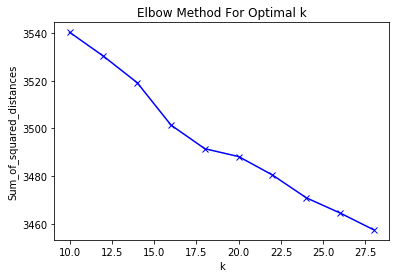

In [40]:
#Test default tokenizer first.
tvec = TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
tvs = tvec.fit_transform(dfs['Description'])
shp = tvs.shape
Sum_of_squared_distances = []
K = range(10,30,2)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tvs)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [56]:

# tvec = TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,3), stop_words=stop_words, tokenizer=tokenize)#limit max appearance of word 
# tvs = tvec.fit_transform(dfs['Description'])
# kmean = KMeans(n_clusters=16)
# kmean.fit(tvs)
# joblib.dump(kmean, 'kmean.pkl')
trvec = TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1,3), stop_words=stop_words, tokenizer=regstemtoken)#limit max appearance of word 
trm = trvec.fit_transform(dfs['Description'])
kreg = KMeans(n_clusters=16)
kreg.fit(trm)
joblib.dump(kreg,'kreg.pkl')


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [''] not in stop_words.
  sorted(inconsistent))


['kreg.pkl']

In [57]:
kms = joblib.load('kmean.pkl')
kmreg = joblib.load('kreg.pkl')
clusters = kms.labels_.tolist()
regclus = kmreg.labels_.tolist()

In [58]:
dfclust = pd.DataFrame()
dfclust['Job Title'] = dfs['Job Title'].copy()
dfclust['Company'] = dfs['Company'].copy()
dfclust['Location'] = dfs['Location'].copy()
dfclust['Cluster'] = clusters
dfclust.head(5)

Job Title                    Company  \
19452                   Investment Analyst                     BOEING   
7183   Data Center Virtualization Engineer                    DataVox   
22504             Onsite Physician Advisor         UnitedHealth Group   
14705   AutoCAD/Office Engineer Internship  Great Lakes Dredge & Dock   
1333                Data Security Engineer                      Paytm   

                  Location  Cluster  
19452          Chicago, IL        7  
7183     Houston, TX 77042        3  
22504   Columbus, OH 43224       12  
14705  Oak Brook, IL 60523        1  
1333           Toronto, ON        8

In [59]:
# dfclust['Cluster'].value_counts()

2     560
14    485
3     471
4     362
13    354
1     325
0     278
12    241
5     237
7     114
15    101
8      77
11     76
9      59
10     42
6      30
Name: Cluster, dtype: int64

In [60]:
dfreg = pd.DataFrame()
dfreg['Job Title'] = dfs['Job Title'].copy()
dfreg['Company'] = dfs['Company'].copy()
dfreg['Location'] = dfs['Location'].copy()
dfreg['Cluster'] = regclus
# dfreg.head(5)

Job Title                    Company  \
19452                   Investment Analyst                     BOEING   
7183   Data Center Virtualization Engineer                    DataVox   
22504             Onsite Physician Advisor         UnitedHealth Group   
14705   AutoCAD/Office Engineer Internship  Great Lakes Dredge & Dock   
1333                Data Security Engineer                      Paytm   

                  Location  Cluster  
19452          Chicago, IL        0  
7183     Houston, TX 77042        2  
22504   Columbus, OH 43224        1  
14705  Oak Brook, IL 60523       11  
1333           Toronto, ON        2

In [61]:
# dfreg['Cluster'].value_counts()

2     836
5     647
10    462
11    401
3     324
8     245
1     220
6     196
7      90
12     84
4      84
14     74
9      59
0      43
13     30
15     17
Name: Cluster, dtype: int64

In [53]:
#Top terms in a cluster
#sort cluster centers by proximity to centroid
order_centroids = kms.cluster_centers_.argsort()[:, ::-1] 
terms = tvec.get_feature_names()
for i in range(16):
    print("Cluster %d words: " % i)
    
    for ind in order_centroids[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % terms[ind])
    print('\n') #add whitespace

Cluster 0 words: 
 technolog 
 chase 
 ’ 
 jpmorgan 
 jpmorgan chase 
 chase co. 
 co. 
 jpmorgan chase co. 
 develop 
 innov 
 team 
 global 
 technologist 
 solut 
 world 
 build 
 financi 
 busi 
 global technolog 
 ’ work 


Cluster 1 words: 
 deloitt 
 mcdonnel 
 burn mcdonnel 
 burn 
 client 
 ’ 
 project 
 amaz 
 100 
 career 
 profession 
 design 
 cognit 
 cultur 
 busi 
 develop 
 deloitt ’ 
 firm 
 construct 
 grow 


Cluster 2 words: 
 market 
 analyt 
 busi 
 team 
 insight 
 ’ 
 product 
 statist 
 manag 
 analysi 
 custom 
 client 
 research 
 develop 
 media 
 model 
 report 
 skill 
 digit 
 campaign 


Cluster 3 words: 
 googl 
 googl 's 
 googl ’ 
 regardless 
 eeo 
 usa 
 's 
 googler 
 product 
 thrive benefit 
 support thrive 
 support thrive benefit 
 team 
 status consid qualifi 
 workplac affirm action 
 veteran status consid 
 opportun workplac affirm 
 workplac affirm 
 requir googl 
 employ commit equal 


Cluster 4 words: 
 -- 
 -- -- 
 -- -- -- 
 -- - 
 --

In [64]:
order_centroidr = kmreg.cluster_centers_.argsort()[:, ::-1] 
termr = trvec.get_feature_names()
for i in range(16):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidr[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termr[ind])
    print('\n') #add whitespace

Cluster 0 words: 
 invest 
 financi 
 goldman 
 chase 
 firm 
 sach 
 goldman sach 
 risk 
 bank 
 busi 
 manag 
 model 
 trade 
 bank  
 client 
 capit 
 invest manag 
 financi servic 
 portfolio 
 asset 


Cluster 1 words: 
 
 research 
 health 
 
 requir 
 report 
 inform 
 manag 
 posit 
 clinic 
 univers 
    
 applic 
 program 
 educ 
 polici 
 abil 
 public 
 project 
 depart 


Cluster 2 words: 
 
 manag 
 busi 
 custom 
 requir 
 support 
 abil 
 project 
 client 
 report 
 process 
 sale 
 servic 
 skill 
 provid 
 includ 
 oper 
 product 
 technic 
 compani 


Cluster 3 words: 
 learn 
 machin 
 machin learn 
 
 algorithm 
 model 
 learn  
 comput 
 engin 
 scienc 
 ai 
 product 
 scientist 
 machin learn  
 deep learn 
 deep 
 build 
 research 
 ml 
 statist 


Cluster 4 words: 
 engin 
 space 
 
 requir 
 u   
 u  
 u 
 test 
 clearanc 
  
   
 aerospac 
 boe 
 lockhe martin 
 lockhe 
 martin 
 program 
 secur 
 technic 
 design 


Cluster 5 words: 
 
 engin 
 softwar 
 de

From the top terms of our clusters, we can see some of these clusters are being highly impacted by company names and the last few clusters have much less interpretable vectors. 

The first couple clusters generate some well defined clusters that seem to be largely affected by industry - business, biotech, web, etc. They are not clustered in the desired way.

Customized tokenizer seems to perform much better because a lot of anomalous punctuation tokens have been removed.

Issues with customized tokenizer are there are many blank vectors

Things to fix:
1. Custom tokenizer needs to be edited to fix blank vector creation
2. Custom tokenizer needs to fix duplicate tokens with spaces
2. Company names need to be removed from description text - perhaps through stop word addition, to prevent impact on clustering
3. Industry key word impacting clustering a lot, skills and role responsibilities are being overwhelmed.

In [11]:
add_stop=[
    'lab',
    'laboratory',
    'company',
    'inc',
    'technology',
    'computer',
    'institute',
    'public',
    '\r'
    'connect'
    'people',
    'fb',
    'g',
    'ge',
    'accomadate',
    'sexuality',
    'sex',
    'orientation',
    'orient',
    'gender',
    'race',
    'ethnicity',
    'ethnic',
    'equal',
    'opportunity',
    'minor',
    'disable',
    'veteran',
    'female',
    'male',
    'employer',
    'employee',
    'network',
    'require',
    'affirm',
    'jp',
    'jpmorgan',
    'chase',
    'usa',
    'america',
    'canada',
    'career',
    'job',
    'compani',
    'location',
    'origin',
    'religion',
    'ident',
    'sexual'
]
stemmer = SnowballStemmer('english')
punc = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'", ''] #remove punctuation for initial analysis
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stopw = nltk.corpus.stopwords.words('english')
stop_words = stop_words.union(stopw)
stop_words = stop_words.union(add_stop)
stem_stop = [stemmer.stem(word) for word in stop_words]
def rst(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
#     tokde = [line.decode('utf-8').strip() for line in tok]
    stem = [stemmer.stem(word) for word in tok]
    h = [n for n in stem if not n in stem_stop]
    return h
def rstu(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
    tokde = [line.decode('utf-8').strip() for line in tok]
    stem = [stemmer.stem(word) for word in tok]
    h = [n for n in stem if not n in stem_stop]
    return h
    
#     return stem
test= "The big world isn't go\ing to go a\r\nw\iay\r. \r \rCompanies will not yield"
#out :[u'big', u'world', u'ing', u'w', u'iay', u'yield']

In [165]:
trvec1 = TfidfVectorizer(max_df=0.8, min_df=.05, ngram_range=(1,3), stop_words=stem_stop, tokenizer=rst)#limit max appearance of word 
trm1 = trvec1.fit_transform(dfs['Description'])
kreg1 = KMeans(n_clusters=16)
kreg1.fit(trm1)
joblib.dump(kreg1,'kreg1.pkl')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p27/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [u'anywh', u'el', u'elsewh', u'everywh', u'ind', u'otherwi', u'plea', u'r', u'somewh', u'v'] not in stop_words.
  sorted(inconsistent))


['kreg1.pkl']

In [129]:
kmreg1 = joblib.load('kreg1.pkl')
regclus1 = kmreg1.labels_.tolist()
dfreg1 = pd.DataFrame()
dfreg1['Job Title'] = dfs['Job Title'].copy()
dfreg1['Company'] = dfs['Company'].copy()
dfreg1['Location'] = dfs['Location'].copy()
dfreg1['Cluster'] = regclus1
dfreg1['Cluster'].value_counts()
order_centroidr = kmreg1.cluster_centers_.argsort()[:, ::-1] 
termr = trvec1.get_feature_names()
for i in range(16):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidr[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termr[ind])
    print('\n') #add whitespace

Cluster 0 words: 
 research 
 clinic 
 cancer 
 health 
 patient 
 biolog 
 studi 
 cell 
 scientif 
 care 
 requir 
 project 
 statist 
 center 
 medic 
 hospit 
 manag 
 includ 
 diseas 
 program 


Cluster 1 words: 
 engin 
 softwar 
 design 
 build 
 product 
 solut 
 cloud 
 custom 
 platform 
 busi 
 aw 
 servic 
 technic 
 use 
 manag 
 architectur 
 big 
 big data 
 code 
 web 


Cluster 2 words: 
 student 
 educ 
 program 
 applic 
 employe 
 posit 
 requir 
 inform 
 univers 
 manag 
 job 
 employ 
 report 
 polici 
 administr 
 school 
 agenc 
 state 
 support 
 depart 


Cluster 3 words: 
 status 
 employ 
 applic 
 busi 
 engin 
 requir 
 protect 
 gender 
 opportun 
 manag 
 product 
 disabl 
 custom 
 nation 
 origin 
 solut 
 technic 
 race 
 color 
 support 


Cluster 4 words: 
 model 
 statist 
 busi 
 analyt 
 product 
 data scienc 
 scienc 
 learn 
 data scientist 
 build 
 scientist 
 insight 
 machin 
 machin learn 
 analysi 
 quantit 
 engin 
 use 
 predict 
 hel

From the output of the top features in each cluster, we can tell the regular expression has drastically improved. There are no longer empy listed features and there are more interpretable differentiations between clusters.

We see cluster 0 is more researched based postings, cluster 1 big data, cluster 2 education, cluster 4 data science, cluster 7 business - finance - accounting.

However cluster 13 and 7 are similar, 10 and 4 are similar, and there are many other clusters with company names and uninterpretable results at the top. There is more work to be done. Must filter out company names next.

In [130]:
dfreg1['Cluster'].value_counts()

1     706
15    669
13    493
3     454
4     326
10    268
7     212
0     185
2     135
14    113
5      72
11     59
6      42
8      34
9      30
12     14
Name: Cluster, dtype: int64

In [13]:
company = dfs.Company.unique()
pcom = []
for item in company:
    spl = word_tokenize(item)
    for itm in spl:
        pcom.append(itm.lower())
pnd = list(set(pcom))
stop_words = stop_words.union(pnd)
# print(stop_words)
# stem_stop = [stemmer.stem(word) for word in stop_words]
def rstnoc(text):
    nre = re.sub(r"(\n)", r" ", text)
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre)
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap)
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower())
#     tokde = [line.decode('utf-8').strip() for line in tok]
    h = [n for n in tok if not n in stop_words]
    stem = [stemmer.stem(word) for word in h]
    return stem

In [166]:
trvecu = TfidfVectorizer(max_df=0.8, min_df=.05, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
trmu = trvecu.fit_transform(dfs['Description'])
kregu = KMeans(n_clusters=16)
kregu.fit(trmu)
joblib.dump(kregu,'kregu.pkl')

['kregu.pkl']

In [167]:
kmregu = joblib.load('kregu.pkl')
regclusu = kmregu.labels_.tolist()
dfregu = pd.DataFrame()
dfregu['Job Title'] = dfs['Job Title'].copy()
dfregu['Company'] = dfs['Company'].copy()
dfregu['Location'] = dfs['Location'].copy()
dfregu['Cluster'] = regclusu
dfregu['Cluster'].value_counts()
order_centroidu = kmregu.cluster_centers_.argsort()[:, ::-1] 
termu = trvecu.get_feature_names()
for i in range(16):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidu[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termu[ind])
    print('\n') #add whitespace

Cluster 0 words: 
 
 softwar 
 engin 
 design 
 product 
 build 
 custom 
 web 
 manag 
 platform 
 technic 
 cloud 
 applic 
 code 
 servic 
 use 
 technolog 
 test 
 high 
 solut 


Cluster 1 words: 
 test 
 autom 
 softwar 
 
 engin 
 requir 
 qualiti 
 product 
 plan 
 perform 
 project 
 manag 
 technic 
 execut 
 script 
 tool 
 case 
 knowledg 
 skill 
 design 


Cluster 2 words: 
 big data 
 engin 
 pipelin 
 big 
 data engin 
 
 aw 
 data pipelin 
 build 
 etl 
 solut 
 busi 
 architectur 
 cloud 
 spark 
 design 
 analyt 
 hadoop 
 platform 
 technolog 


Cluster 3 words: 
 
 status 
 applic 
 employ 
 engin 
 requir 
 protect 
 disabl 
 nation 
 custom 
 origin 
 includ 
 busi 
 color 
 law 
 nation origin 
 religion 
 regard 
 qualifi 
 program 


Cluster 4 words: 
 research 
 
 statist 
 analysi 
 scienc 
 scientif 
 comput 
 project 
 studi 
 posit 
 includ 
 program 
 skill 
 scientist 
 collabor 
 health 
 applic 
 candid 
 requir 
 polici 


Cluster 5 words: 
 clinic 


In [168]:
dfregu['Cluster'].value_counts()

9     508
10    429
0     420
6     319
11    293
3     292
13    264
2     230
8     170
14    168
12    168
5     134
4     132
7     129
1      91
15     65
Name: Cluster, dtype: int64

In [169]:
print(len(trvecu.get_feature_names()))
print(len(trvec1.get_feature_names()))
print(len(trvec.get_feature_names()))
#reduced feature space from 66000 to 1100!!!!!!!

1155
1178
66012


In [14]:
tfru= TfidfVectorizer(max_df=0.65, min_df=30, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
tvru = tfru.fit_transform(dfs['Description'])
Sum_of_squared_distances = []
K = range(5,20,1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tvru)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#reduced Sum of squared distances to 3.3k from 10k 

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

KeyboardInterrupt: 

In [15]:
tfd = TfidfVectorizer(max_df=0.65, min_df=20, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
tvt = tfd.fit_transform(dfs['Description'])
krt = KMeans(n_clusters=12)
krt.fit(tvt)
joblib.dump(krt,'krt.pkl')

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

['krt.pkl']

In [16]:
kmt = joblib.load('krt.pkl')
regt = kmt.labels_.tolist()
dfrt = pd.DataFrame()
dfrt['Job Title'] = dfs['Job Title'].copy()
dfrt['Company'] = dfs['Company'].copy()
dfrt['Location'] = dfs['Location'].copy()
dfrt['Cluster'] = regt
dfrt['Cluster'].value_counts()
order_centroidt = kmt.cluster_centers_.argsort()[:, ::-1] 
termt = tfd.get_feature_names()
for i in range(12):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidt[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termt[ind])
    print('\n') #add whitespace

Cluster 0 words: 
 model 
 statist 
 algorithm 
 scientist 
 predict 
 languag 
 techniqu 
 deep 
 python 
 quantit 
 problem 
 mathemat 
 product 
 larg 
 understand 
 r 
 experi 
 ml 
 strong 
 program 


Cluster 1 words: 
 help 
 product 
 make 
 analyst 
 world 
 strong 
 look 
 role 
 grow 
 understand 
 creat 
 manag 
 excel 
 program 
 provid 
 passion 
 drive 
 report 
 content 
 custom 


Cluster 2 words: 
 aw 
 architectur 
 code 
 experi 
 applic 
 infrastructur 
 product 
 build 
 pipelin 
 custom 
 java 
 distribut 
 implement 
 databas 
 scalabl 
 like 
 integr 
 python 
 knowledg 
 end 


Cluster 3 words: 
 equip 
 perform 
 process 
 provid 
 product 
 custom 
 knowledg 
 oper 
 applic 
 hardwar 
 respons 
 materi 
 posit 
 relat 
 standard 
 maintain 
 facil 
 troubleshoot 
 ensur 
 time 


Cluster 4 words: 
 custom 
 product 
 manag 
 provid 
 drive 
 success 
 help 
 process 
 strong 
 need 
 role 
 account 
 make 
 understand 
 respons 
 applic 
 ensur 
 problem 
 d

In [17]:
dfrt['Cluster'].value_counts()
#cluster 9 is facebook job applications with similar sentences, perhaps will use doc2vec to find similar sentences to be cleaned out of dataset


1     569
2     530
8     438
3     418
0     403
6     389
4     319
11    285
7     229
5     155
9      45
10     32
Name: Cluster, dtype: int64

In [18]:
print(len(termt))

7077


In [20]:
dist = 1 - cosine_similarity(tvt)
# pca = PCA(n_components=50)
# pcad = pca.fit_transform(dist)
tpc = TSNE(n_components=2).fit_transform(dist)

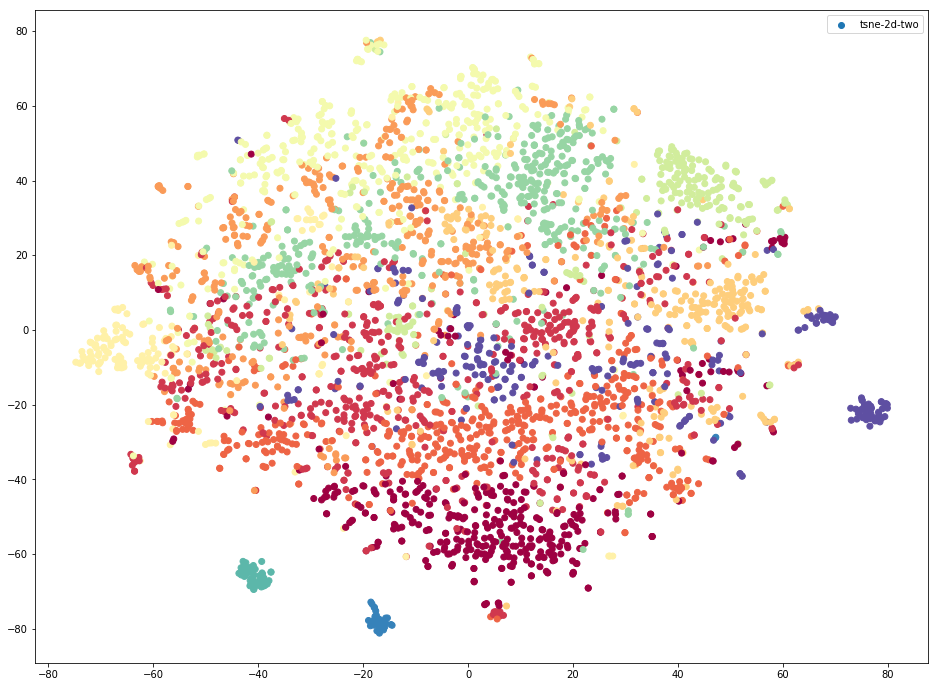

In [26]:
import seaborn as sns
dfrt['tsne-2d-one'] = tpc[:,0]
dfrt['tsne-2d-two'] = tpc[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

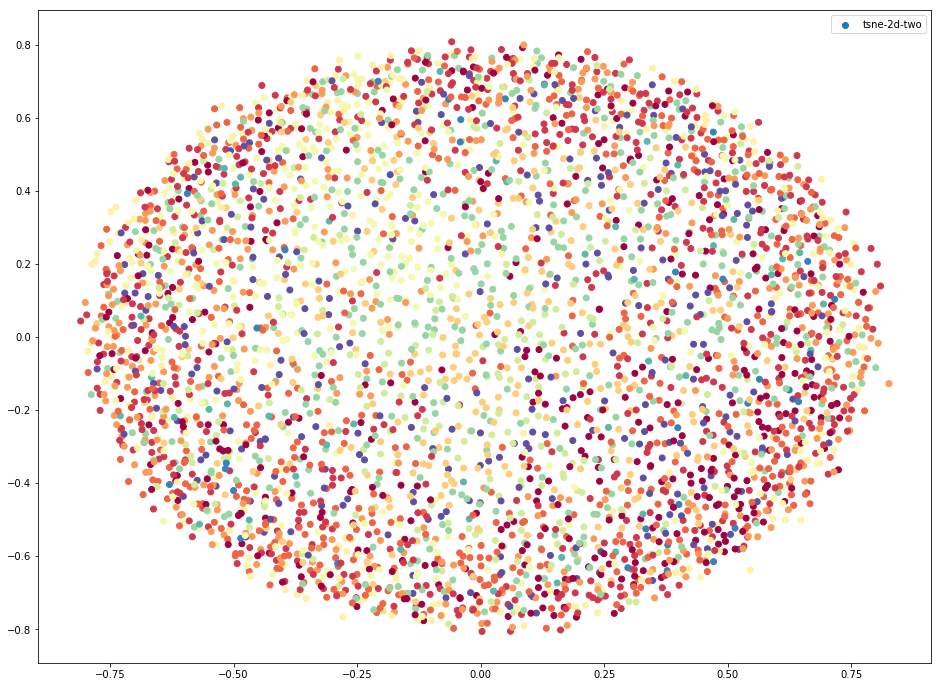

In [29]:
md = MDS(n_components=2,  dissimilarity='precomputed')
pos = md.fit_transform(dist)
dfrt['tsne-2d-one'] = pos[:,0]
dfrt['tsne-2d-two'] = pos[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

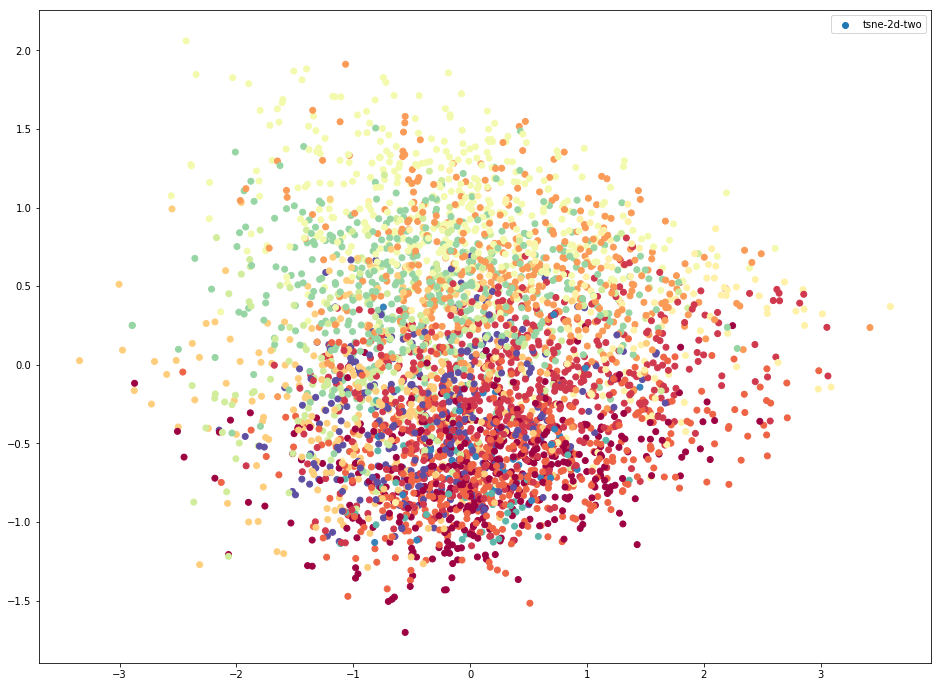

In [30]:
PC = PCA(n_components=2)
posi = PC.fit_transform(dist)
dfrt['tsne-2d-one'] = posi[:,0]
dfrt['tsne-2d-two'] = posi[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

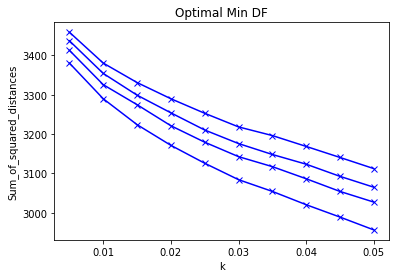

In [35]:
Sum_of_squared_distances = []
maxrange = np.linspace(0.5, 0.8, 4)
minrange = np.linspace(0.005, 0.05, 10)
for md in maxrange:
    Sum_of_squared_distances = []
    for nd in minrange:
        tdvec = TfidfVectorizer(max_df=md, min_df=nd, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
        tdidf = tdvec.fit_transform(dfs['Description'])
        km = KMeans(n_clusters=12)
        km = km.fit(tdidf)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(minrange, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Optimal Min DF')

    
        

# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
plt.show()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

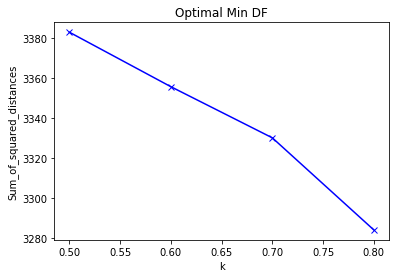

In [36]:
#forgot to add color or label for the plot!!
Sum_of_squared_distances = []
maxrange = np.linspace(0.5, 0.8, 4)
minrange = np.linspace(0.005, 0.05, 10)
Sum_of_squared_distances = []
for md in maxrange:
    tdvec = TfidfVectorizer(max_df=md, min_df=.01, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
    tdidf = tdvec.fit_transform(dfs['Description'])
    km = KMeans(n_clusters=12)
    km = km.fit(tdidf)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(maxrange, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Optimal Min DF')
plt.show()


In [42]:
tfd = TfidfVectorizer(max_df=0.8, min_df=.025, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
tvt = tfd.fit_transform(dfs['Description'])
krt = KMeans(n_clusters=12)
krt.fit(tvt)
kmt = krt
regt = kmt.labels_.tolist()
dfrt = pd.DataFrame()
dfrt['Job Title'] = dfs['Job Title'].copy()
dfrt['Company'] = dfs['Company'].copy()
dfrt['Location'] = dfs['Location'].copy()
dfrt['Description'] = dfs['Description'].copy()
dfrt['Cluster'] = regt
dfrt['Cluster'].value_counts()
order_centroidt = kmt.cluster_centers_.argsort()[:, ::-1] 
termt = tfd.get_feature_names()
for i in range(12):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidt[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termt[ind])
    print('\n') #add whitespace

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

Cluster 0 words: 
 model 
 statist 
 algorithm 
 
 scientist 
 use 
 predict 
 techniqu 
 quantit 
 languag 
 develop 
 python 
 deep 
 mathemat 
 problem 
 r 
 larg 
 skill 
 understand 
 product 


Cluster 1 words: 
 hardwar 
 configur 
 server 
 troubleshoot 
 applic 
 custom 
 issu 
 provid 
 infrastructur 
 knowledg 
 linux 
 
 window 
 requir 
 incid 
 oper 
 perform 
 instal 
 includ 
 skill 


Cluster 2 words: 
 client 
 
 skill 
 provid 
 firm 
 manag 
 help 
 requir 
 strong 
 includ 
 analyst 
 engag 
 develop 
 process 
 custom 
 role 
 deliv 
 understand 
 help client 
 industri 


Cluster 3 words: 
 aw 
 
 architectur 
 develop 
 code 
 applic 
 use 
 build 
 java 
 infrastructur 
 knowledg 
 custom 
 requir 
 implement 
 product 
 distribut 
 experi 
 pipelin 
 strong 
 skill 


Cluster 4 words: 
 requir 
 
 perform 
 process 
 report 
 duti 
 equip 
 includ 
 relat 
 procedur 
 applic 
 posit 
 provid 
 skill 
 assign 
 prepar 
 knowledg 
 program 
 respons 
 maintain 


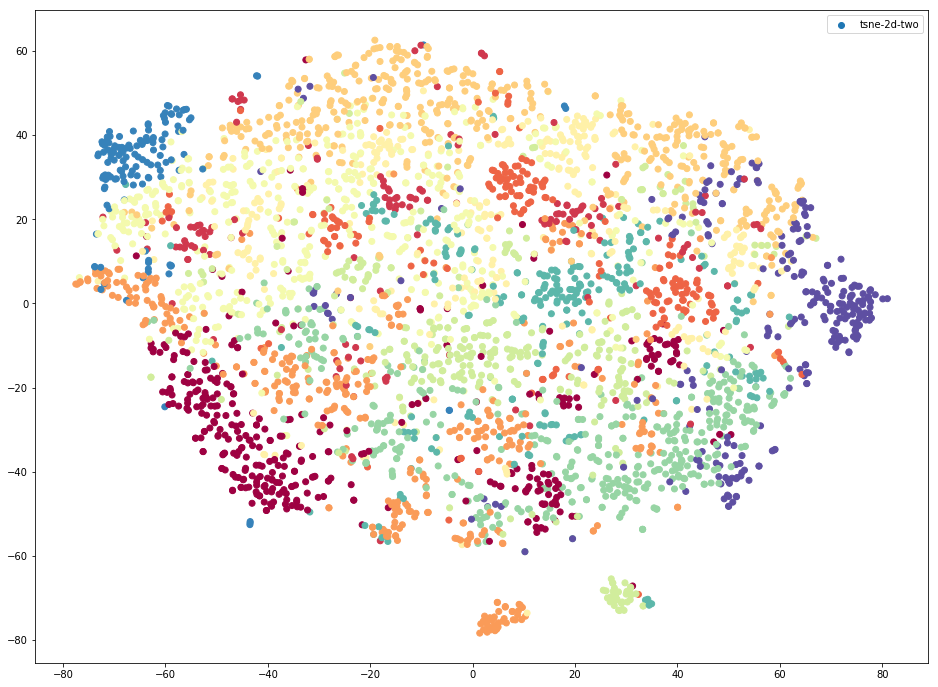

In [43]:
dist = 1 - cosine_similarity(tvt)
# pca = PCA(n_components=50)
# pcad = pca.fit_transform(dist)
tpc = TSNE(n_components=2).fit_transform(dist)
import seaborn as sns
dfrt['tsne-2d-one'] = tpc[:,0]
dfrt['tsne-2d-two'] = tpc[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

In [45]:
dfrt['Cluster'].value_counts()
# dfi = dfrt.loc[dfrt['Cluster']==0]

6     471
4     469
8     435
3     412
0     362
7     360
5     304
11    260
9     252
2     203
1     150
10    134
Name: Cluster, dtype: int64

In [52]:
from sklearn.cluster import AgglomerativeClustering
tfvec = TfidfVectorizer(max_df=0.8, min_df=.025, ngram_range=(1,2), stop_words=stop_words, tokenizer=rstnoc)#limit max appearance of word 
tfmatrix = tfvec.fit_transform(dfs['Description'])
linkv = ['ward','average']
affinv = ['euclidean']
results = {}
for xv in linkv:
    label = xv + 'raw.pkl'
    agc = AgglomerativeClustering(n_clusters=10,linkage = xv, affinity = 'euclidean')
    agc.fit_predict(tfmatrix.todense())
    joblib.dump(agc,label)
        

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['12', '1stdib', '20', '360train', 'ade', 'algonquin', 'altran', 'ar', 'arcadia', 'aric', 'bian', 'bristol', 'broker', 'c3', 'car', 'cedar', 'chain', 'chiat', 'cimpress', 'ck', 'coca', 'cola', 'cor', 'dana', 'day', 'dealer', 'dkmanufactur', 'e', 'empir', 'everestlab', 'farber', 'foil', 'forman', 'gro', 'handi', 'hiretu', 'hiv', 'ice', 'imanag', 'jdedwardsrecruit', 'kla', 'lavalin', 'li', 'logic20', 'lunenfeld', 'macaulay', 'math', 'metrolink', 'mfg', 'mid', 'miracl', 'mlb', 'movework', 'mr', 'myer', 'oreal', 'pepsi', 'pierc', 'pit', 'poli', 'purchas', 'r', 'rev', 'roc', 'rom', 'ruth', 'scrra', 'securesoftwar', 'snc', 'sonoma', 'splice', 'studi', 'tacoma', 'tanenbaum', 'tbwa', 'teco', 'tencor', 'tra', 'transact', 'transfix', 'trusourcelab', 'u', 'vistaprint

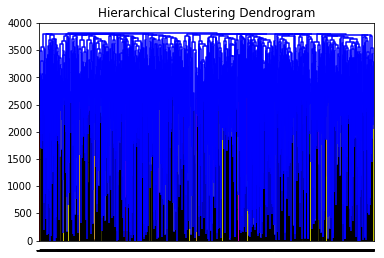

In [54]:
from scipy.cluster.hierarchy import dendrogram
ward = joblib.load('wardraw.pkl')

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(ward, labels=ward.labels_)
plt.show()

In [61]:
dfrt['HCluster'] = ward.labels_
print(ward.labels_)
dfrt.describe()

[5 5 4 ... 0 9 9]


Cluster  tsne-2d-one  tsne-2d-two     HCluster
count  3812.000000  3812.000000  3812.000000  3812.000000
mean      5.373033    -0.066293     0.774765     2.952781
std       3.134003    31.193357    38.212631     2.696076
min       0.000000   -67.401474   -76.955811     0.000000
25%       3.000000   -24.573878   -30.082723     0.000000
50%       6.000000    -0.416519    -0.428754     3.000000
75%       8.000000    24.427175    30.832974     4.000000
max      11.000000    69.776192    82.389183     9.000000

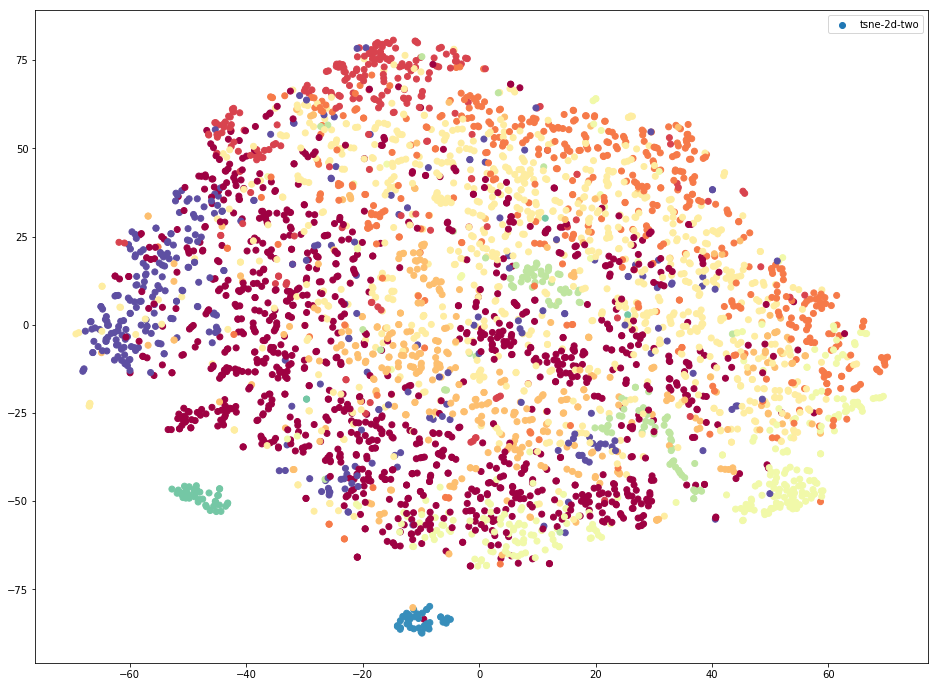

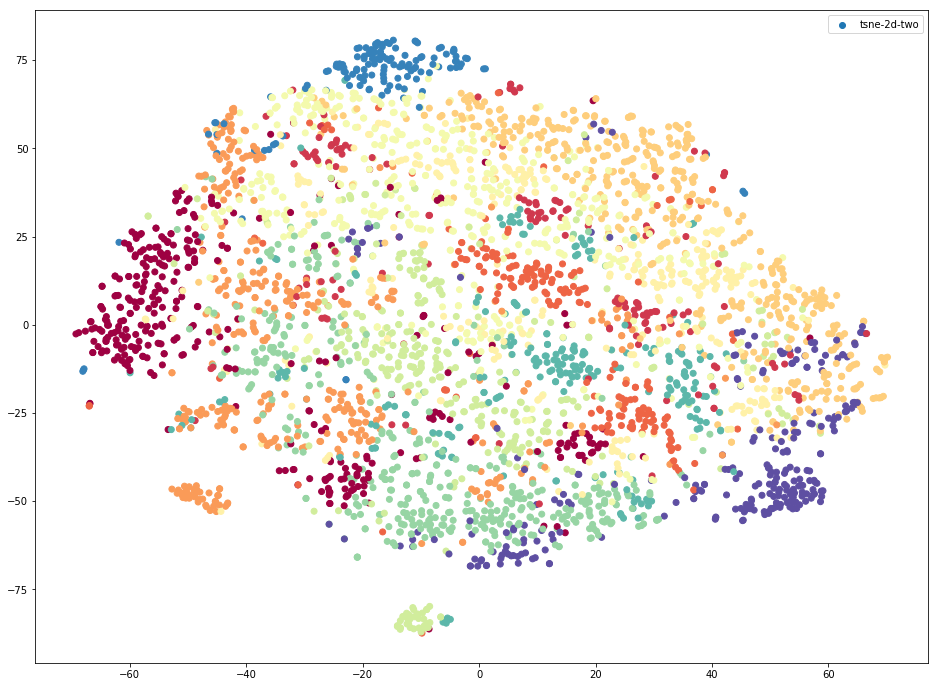

In [64]:
dist = 1 - cosine_similarity(tfmatrix)
# pca = PCA(n_components=50)
# pcad = pca.fit_transform(dist)
tpc = TSNE(n_components=2).fit_transform(dist)
import seaborn as sns
dfrt['tsne-2d-one'] = tpc[:,0]
dfrt['tsne-2d-two'] = tpc[:,1]
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['HCluster'], cmap='Spectral')
plt.legend()
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['Cluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()

In [ ]:
order_centroidt = kmt.cluster_centers_.argsort()[:, ::-1] 
termt = tfd.get_feature_names()
for i in range(12):
    print("Cluster %d words: " % i)
    
    for ind in order_centroidt[i, :20]: #replace 6 with n words per cluster
        print(' %s ' % termt[ind])
    print('\n') #add whitespace

1

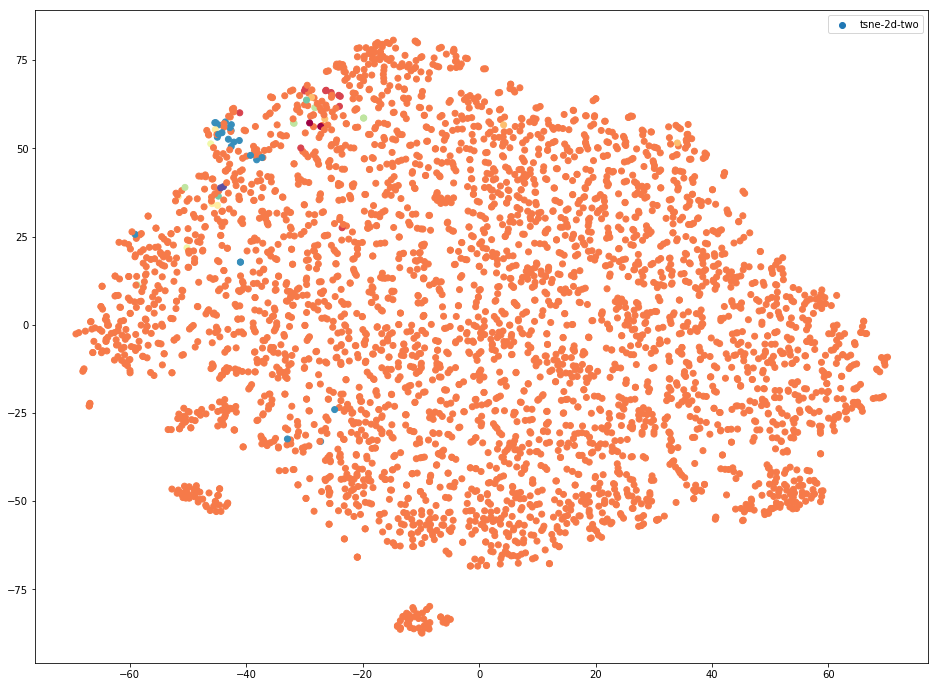

In [76]:
avgh = joblib.load('averageraw.pkl')
dfrt['ACluster'] = avgh.labels_
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['ACluster'], cmap='Spectral')
plt.legend()
# sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two", data=dfrt)
plt.show()
#average sucked

In [69]:
from sklearn.cluster import MeanShift
ms = MeanShift()
ms.fit_predict(tfmatrix.todense())

joblib.dump(ms,'meanshift.pkl')



['meanshift.pkl']

In [70]:
print(ms.labels_)

[0 0 0 ... 0 0 0]


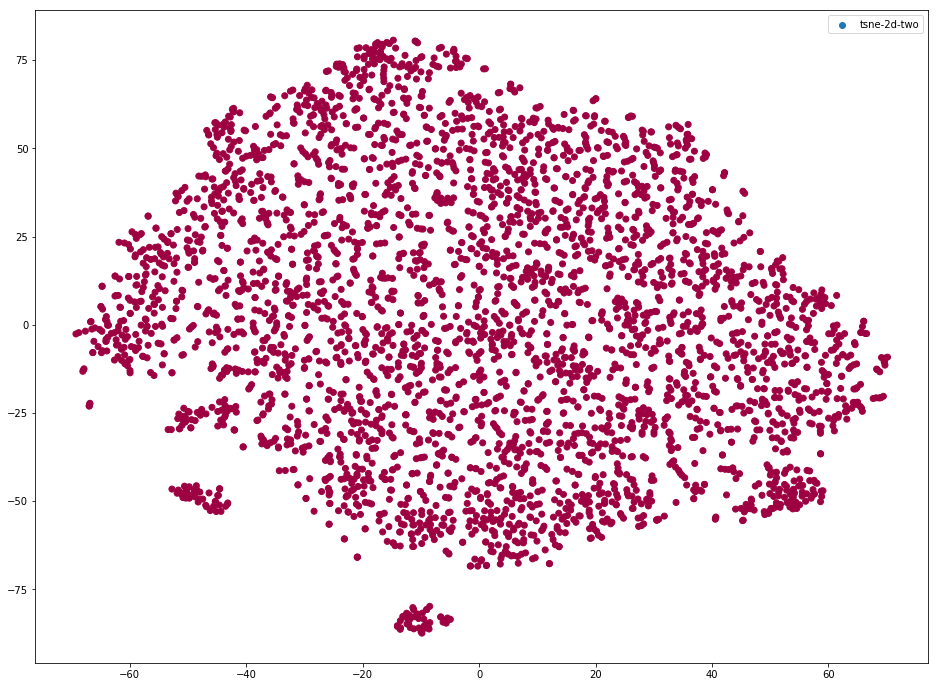

In [71]:
msm = joblib.load('meanshift.pkl')
dfrt['MSCluster'] = msm.labels_
plt.figure(figsize=(16,12))
plt.scatter(dfrt['tsne-2d-one'],dfrt['tsne-2d-two'], c=dfrt['MSCluster'], cmap='Spectral')
plt.legend()
plt.show()